In [12]:
%matplotlib inline
from mplfonts.bin.cli import init
init()
from mplfonts import use_font
use_font('SimHei')
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 4)
import pandas as pd
import numpy as np

adult = pd.read_csv("adult_with_pii.csv")
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0


# 合成数据

```{admonition} 学习目标
阅读本章后，您将能够：
- 描述差分隐私合成数据的思想并解释其作用
- 定义数据的合成表示，用于后续生成合成数据
- 定义*边际*，并实现计算边际的代码
- 实现生成低维合成数据的简单差分隐私算法
- 描述生成高维合成数据的挑战
```

本章，我们将研究使用差分隐私算法生成*合成数据*（Synthetic Data）的问题。严格来说，合成数据生成算法的输入是一个*原始数据集*，其输出是维度相同（即列数和行数相同）的*合成数据集*。进一步，我们希望合成数据集的数据与原始数据集的对应数据满足相同的性质。例如，如果我们将美国人口普查数据集作为原始数据集，我们期望合成数据集与原始数据集有相似的人群年龄分布，并保留列之间的相关性（如年龄和职业的相关性）。

大多数合成数据生成算法都依赖于原始数据集的*合成表示*（Synthetic Representation）。合成表示和原始数据的维度不同，但可以用于回答原始数据的问询。例如，如果我们只关心年龄的范围问询，那么我们可以统计原始数据中每个年龄的人数，生成年龄直方图，并使用直方图回答问询。该直方图就是一个适合回答一些问询的数据集*合成表示*。但由于和原始数据集的维度不同，因此合成表示不是*合成数据*。

部分算法简单地使用合成表示来回答问询。部分算法使用合成表示生成合成数据集。下面，我们将研究直方图合成表示，并介绍基于直方图生成合成数据集的几种方法。

## 合成表示：直方图

我们已经学习过很多差分隐私直方图问询算法了。由于可以直接使用并行组合性，直方图是一种适用于差分隐私的典型数据分析场景。我们也学习过*范围问询*的概念，虽然我们不常使用这个术语来表示范围问询。作为合成数据的第一步，我们先为原始数据集中的一列数据设计一个能够回答范围问询的合成表示。

*范围问询*统计数据集中落在给定范围内值的行数。例如，"有多少参与者的年龄在21到33岁之间？"是一个范围问询。

In [13]:
def range_query(df, col, a, b):
    return len(df[(df[col] >= a) & (df[col] < b)])

range_query(adult, 'Age', 21, 33)

9878

我们可以把0到100之间每个年龄的计数值定义为一个直方图问询，并应用范围问询计算每个年龄的人数。问询结果看起来很像数据调用`plt.hist`函数的输出结果，因为我们本质上只是把这个函数又手动实现了一遍。

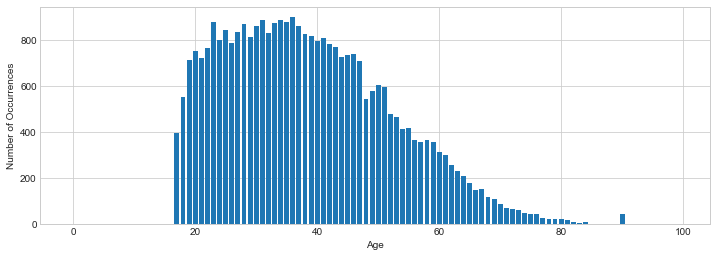

In [14]:
bins = list(range(0, 100))
counts = [range_query(adult, 'Age', b, b+1) for b in bins]
plt.xlabel('年龄')
plt.ylabel('出现次数')
plt.bar(bins, counts);

我们可以将直方图中的各个计数结果作为原始数据的合成表示！为了回答一个范围问询，我们可以将落在范围内所有年龄的计数结果相加，作为此问询的回复结果。

In [15]:
def range_query_synth(syn_rep, a, b):
    total = 0
    for i in range(a, b):
        total += syn_rep[i]
    return total

In [16]:
range_query_synth(counts, 21, 33)

9878

注意，无论是在原始数据集还是在合成表示上执行范围问询，我们都得到了*完全*相同的结果。（至少在回答年龄范围问询时）我们没有丢失原始数据集中的任何信息。

## 增加差分隐私

我们可以很容易使合成表示满足差分隐私，只需要在直方图中的每个计数值上单独增加拉普拉斯噪声。根据并行组合性，这一机制满足$\epsilon$-差分隐私。

In [17]:
epsilon = 1
dp_syn_rep = [laplace_mech(c, 1, epsilon) for c in counts]

我们可以使用与之前相同的函数，基于差分隐私合成表示回答范围问询。根据后处理性，得到的问询也满足$\epsilon$-差分隐私。此外，由于依赖的是后处理性，我们可以在不消耗任何额外隐私预算的条件下回答任意数量的年龄范围问询。

In [18]:
range_query_synth(dp_syn_rep, 21, 33)

9874.173573484375

问询结果的准确度怎么样呢？对于年龄范围比较小的问询，我们从合成表示得到的问询结果与直接应用拉普拉斯机制得到的问询结果有非常相似的准确度。例如：

In [19]:
true_answer = range_query(adult, 'Age', 30, 31)
print('合成表示误差率：{}'.format(pct_error(true_answer, range_query_synth(dp_syn_rep, 30, 31))))
print('拉普拉斯机制误差率：{}'.format(pct_error(true_answer, laplace_mech(true_answer, 1, epsilon))))

Synthetic representation error: 0.1843819197936098
Laplace mechanism error: 0.31050813456829274


计数值会随着年龄范围的增大而增大，我们认为相对误差应该会变小。我们已经多次印证过这个事实了：更大的分组意味着更强的信号，这会使统计结果的信噪比变低，相对误差也随之降低。如果直接使用拉普拉斯机制回复问询，我们能看到事实的确如此。然而，当使用合成表示回复问询时，我们会将很多小分组的噪声也加在一起。因此，信号虽然变强了，但噪声也变大了！当使用合成表示回复问询时，我们发现大年龄范围问询的相对误差与小年龄范围问询的相对误差几乎相同。相对误差与*问询范围无关*，这一现象恰恰与拉普拉斯机制相反！

In [20]:
true_answer = range_query(adult, 'Age', 30, 71)
print('合成表示误差率：{}'.format(pct_error(true_answer, range_query_synth(dp_syn_rep, 30, 71))))
print('拉普拉斯机制误差率：{}'.format(pct_error(true_answer, laplace_mech(true_answer, 1, epsilon))))

Synthetic representation error: 0.04946493324009918
Laplace mechanism error: 0.008957148504819611


这一差异体现出了合成表示的缺点：它可以回答所覆盖范围内的任何范围问询，但可能无法提供与拉普拉斯机制相同的准确度。合成表示的主要优势是可以在无需额外隐私预算的条件下支持回复无限多次问询。合成表示的主要劣势是精度损失。

## 生成列表数据

合成表示的下一步是基于合成表示来*合成数据*。为了实现这一点，我们希望将合成表示视为一个可以用于估计原始数据潜在分布的概率分布函数，进而可以根据此概率分布采样，得到合成数据集。这里我们忽略其他数据列，只考虑单列数据，单列数据的概率分布称为[*边际分布*](https://en.wikipedia.org/wiki/Marginal_distribution)（Marginal Distribution）。确切地说，应该叫*单维边际分布*（1-way Marginal）。

我们这里的策略很简单：先对直方图的每个属性值计数；随后归一化计数结果，使所有技术结果的和为1；最后将得到的归一化视为概率值。得到了这些概率值后，我们就可以基于这些概率值所表示的概率分布采样了。方法很简单，根据直方图属性值对应的概率值随机选择一个属性值即可。我们的第一步是获得计数值，保证结果中没有负数，并将这些计数值归一化，使他们的求和值等于1：

In [21]:
dp_syn_rep_nn = np.clip(dp_syn_rep, 0, None)
syn_normalized = dp_syn_rep_nn / np.sum(dp_syn_rep_nn)
np.sum(syn_normalized)

1.0

注意，由于归一化直方图中的所有计数值的求和结果为1，因此现在我们可以把它们看作对应属性值的概率值了。如果画出归一化的直方图，我们可以看到此直方图和原始直方图非常相似（也就是说，概率分布图的形状看起来和原始数据集的形状非常相似）。这个结果没有超出我们的预估，这些概率值*仍然是*简单的计数值，我们只是对它们进行了缩放处理。

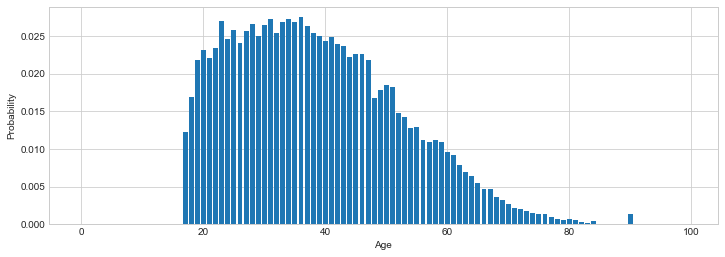

In [22]:
plt.xlabel('年龄')
plt.ylabel('概率')
plt.bar(bins, syn_normalized);

最后一步是基于这些概率值生成新的样本。我们可以使用`np.random.choice`函数，其第一个输入参数（对应参数`p`）可以为表示各个属性值采样概率的概率列表。此函数实现的就是我们采样任务所需的加权采样功能。因为获得计数值的过程已经满足差分隐私，我们可以在无需额外隐私预算的条件下生成任意数量的样本。

In [23]:
def gen_samples(n):
    return np.random.choice(bins, n, p=syn_normalized)

syn_data = pd.DataFrame(gen_samples(5), columns=['Age'])
syn_data

,Age
0,50
1,38
2,62
3,20
4,27


该方法生成的样本分布与原始数据集的分布大体一致。这样一来，我们可以用生成的合成数据集替代原始数据集，基于合成数据集回复问询。特别地，如果我们画出一个超大规模合成数据集的年龄直方图，我们可以看到此图的形状与原始数据集的形状相同。

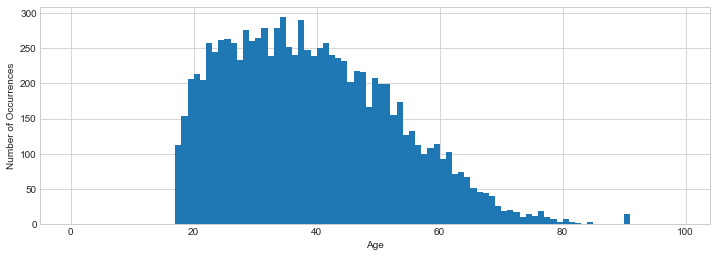

In [24]:
syn_data = pd.DataFrame(gen_samples(10000), columns=['Age'])
plt.xlabel('年龄')
plt.ylabel('出现次数')
plt.hist(syn_data['Age'], bins=bins);

我们现在可以回答均值问询、范围问询等等之前看到的一些问询了：

In [26]:
print('年龄均值，合成结果：{}'.format(np.mean(syn_data['Age'])))
print('年龄均值，真实结果：{}'.format(np.mean(adult['Age'])))
print('误差率：{}'.format(pct_error(np.mean(syn_data['Age']), np.mean(adult['Age']))))

Mean age, synthetic: 38.6697
Mean age, true answer: 38.58164675532078
Percent error: 0.22770604550647133


In [27]:
print('年龄范围问询，合成结果：{}'.format(range_query(syn_data, 'Age', 20, 65)))
print('年龄范围问询，真实结果：{}'.format(range_query(adult, 'Age', 20, 65)))
print('误差率：{}'.format(pct_error(range_query(adult, 'Age', 20, 65), range_query(syn_data, 'Age', 20, 65))))

Mean age, synthetic: 9148
Mean age, true answer: 29568
Percent error: 69.06114718614718


我们的均值问询的误差率相当低（尽管仍然高于直接应用拉普拉斯机制的误差率）。但是，范围问询的误差非常大！不过，这只是因为合成数据集的大小与原始数据集不一致。我们只生成了10,000个样本，而原始数据集超过30,000行。我们可以执行额外的差分隐私问询来确定原始数据集的行数，进而生成相同行数的新合成数据集。这样以来，范围问询的准确率就会得到提高。

In [17]:
n = laplace_mech(len(adult), 1, 1.0)
syn_data = pd.DataFrame(gen_samples(int(n)), columns=['Age'])

print('年龄范围问询，合成结果：{}'.format(range_query(syn_data, 'Age', 20, 65)))
print('年龄范围问询，真实结果：{}'.format(range_query(adult, 'Age', 20, 65)))
print('误差率：{}'.format(pct_error(range_query(adult, 'Age', 20, 65), range_query(syn_data, 'Age', 20, 65))))

Mean age, synthetic: 29597
Mean age, true answer: 29568
Percent error: 0.09807900432900432


可以看出，问询回复的误差率很低，这正是我们期望得到的结果。

## 生成更多数据列

我们现在已经生成了与原始数据集行数相等的合成数据集。此合成数据集确实有助于回答有关原始数据集的问询。然而，这个合成数据集只包含一列数据！我们如何生成包含更多列数据的合成数据集呢？

有两种基本实现方法。我们可以分别对$k$列数据重复上述过程（生成$k$个单维边际），得到$k$个相互独立、各包含一列数据的合成数据集。随后，我们将这些数据集合并在一起，构建出一个包含$k$列的合成数据集。这是一种很直接的实现方法，但由于我们会单独考虑各列数据，因此得到的合成数据集会丢失列*之间*的相关性信息。例如，原始数据集中的年龄和职业可能存在相关性（举例来说，职业为"经理"的人会更年长一些）。如果我们分别考虑各列数据，则合成数据集中年龄为18岁的*人数*和职位为经理的*人数*是正确的，但年龄为18岁的经理人数可能会错得离谱。

另一种方法是在生成合成数据时考虑多个数据列。例如，我们可以同时考虑年龄和职业这两列数据，分别计算出有多少18岁的经理，有多少19岁的经理等等。这一改进方法所得到的结果称为两维边缘分布（2-way Marginal Distribution）。同时考虑所有可能的年龄和职业组合的这一做法正是我们之前构建列联表的方法！例如：

In [19]:
ct = pd.crosstab(adult['Age'], adult['Occupation'])
ct.head()

Occupation,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
Age,,,,,,,,,,,,,,
17,23,0,14,1,9,40,2,129,8,10,3,87,1,3
18,55,0,17,6,14,50,17,152,4,10,5,115,2,8
19,102,0,40,12,24,65,30,166,3,18,3,112,8,16
20,117,0,35,15,23,81,41,139,3,28,9,108,14,24
21,121,0,59,18,25,51,51,142,4,30,7,93,16,14


我们现在可以完全沿用之前的做法：在各个计数值上增加噪声后归一化处理，将得到的计数结果视为概率值！现在，每个计数结果对应的是年龄和职业这*一对*属性值。因此，当我们从这一分布采样时，得到是同时满足这两个属性值的合成数据。

In [20]:
dp_ct = ct.applymap(lambda x: max(laplace_mech(x, 1, 1), 0))
dp_vals = dp_ct.stack().reset_index().values.tolist()
probs = [p for _,_,p in dp_vals]
vals = [(a,b) for a,b,_ in dp_vals]
probs_norm = probs / np.sum(probs)
list(zip(vals, probs_norm))[0]

((17, 'Adm-clerical'), 0.000776459023220336)

查看所得概率中的第一个元素，我们发现有0.07%的机会生成表示"17岁文书工作者"的数据行。现在，我们已经准确好生成合成数据集了！首先生成`vals`列的取值索引表，随后根据取值索引表生成`vals`的各个行。我们之所以这样实现，原因是`np.random.choice`函数的第一个参数不能以元组列表作为输入。

In [21]:
indices = range(0, len(vals))
n = laplace_mech(len(adult), 1, 1.0)
gen_indices = np.random.choice(indices, int(n), p=probs_norm)
syn_data = [vals[i] for i in gen_indices]

syn_df = pd.DataFrame(syn_data, columns=['Age', 'Occupation'])
syn_df.head()

,Age,Occupation
0,19,Other-service
1,53,Other-service
2,28,Sales
3,30,Craft-repair
4,52,Prof-specialty


同时考虑两个数据列的缺点是问询的准确度会降低。如果我们进一步同时考虑更多的数据列，即构建$n$逐渐增加的$n$维边际（$n$-way Marginal），我们会看到和列联表相同的效果：每个计数值会变得更小，因此相对于噪声来说数据体现出的信号会变小，准确度因此降低。我们可以通过绘制新合成数据集的年龄直方图，从视觉上进一步观察出这一效果。注意到，图像的形状基本正确，但与原始数据集或单独为年龄列加差分隐私的计数值相比，图像的平滑度变差了一些。

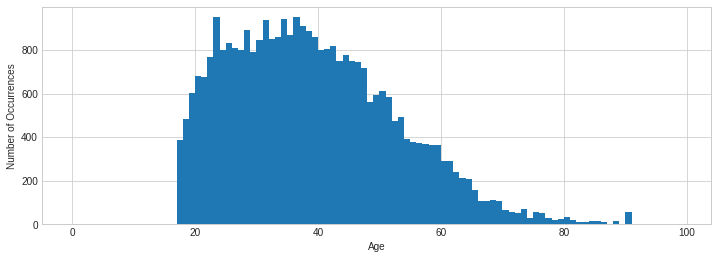

In [22]:
plt.xlabel('年龄')
plt.ylabel('出现次数')
plt.hist(syn_df['Age'], bins=bins);

当我们只对年龄列进行问询时，会看到相同的准确度损失问题：

In [24]:
real_answer = range_query(adult, 'Age', 20, 30)
syn_answer = range_query(syn_df, 'Age', 20, 30)
print('使用合成数据的误差率：', pct_error(real_answer, syn_answer))

Percent error using synthetic data: 14.986342190216043


/home/jnear/anaconda3/envs/book/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## 总结

- 数据集的*合成表示*可以回答有关原始数据集的问询
- 一种常用的合成表示是直方图，可以通过在计数值上增加噪声来实现差分隐私
- 将计数值视为概率后，可以根据直方图合成表示生成与原始数据集规模相同的*合成数据集*：将计数值归一化为求和等于1，进而使用归一化计数值作为概率，依概率采样生成直方图各属性值的数据
- 归一化直方图表示的是涵盖单数据列信息的*单维边际分布*
- 单维边际无法涵盖数据列之间的相关性
- 如果想生成包含多列数据的合成数据集，我们可以使用多个单维边际，也可以构造$n>1$的$n$维边际
- 随着$n$的增加，差分隐私$n$维边际的相对噪声会变大，因为更大的$n$意味着直方图各个计数值变得更小
- 因此，生成合成数据集的挑战在于：
  - 使用多个单维边际会丢失数据列之间的相关性
  - 使用单个$n$维边际往往带来较低的准确度
- 在很多情况下，似乎不可能生成准确度又高，又能涵盖多数据列相关性的合成数据集